In [1]:
from epi_model import *

In [2]:
from simulation_helper import *

In [3]:
from simulation_manager import simulation_manager

In [4]:
from frozendict import frozendict as fzd

In [5]:
dfs, modelsets = {},{}

In [12]:
names = [
    'HS1-R0_coeffvar',
    'HS2-R0_coeffvar',
    'synthetic_3-R0_coeffvar'
]

In [13]:
def get_bounds(l, q, z=1.96):
    l = sorted(l)
    n = len(l)

    i = int( np.ceil( n*q - z*np.sqrt(n*q*(1-q)) ) )
    j = int( np.ceil( n*q + z*np.sqrt(n*q*(1-q)) ) )

    return (l[i], l[j])

In [15]:
for name in names:
    
    print(f'loading {name}')

    sim_m = simulation_manager()
    sim_m.load_models(name)

    rows = []
    for k,ms in sim_m.models.items():
        rows.append(sim_m.info(k))

    df = pd.DataFrame.from_records(rows)

    #df.head()
    
    dfs[name] = df
    modelsets[name] = sim_m

loading HS1-R0_coeffvar
loading HS2-R0_coeffvar
loading synthetic_3-R0_coeffvar


In [16]:
todel = []
for x in manager.models:
    if 'R0_coeffvar' not in x:
        todel.append(x)

for x in todel:
    del manager.models[x]

NameError: name 'manager' is not defined

In [ ]:
sorted(set(x['R0_coeffvar'] for x in manager.models))

In [17]:
comparisons = {
    #'VACCINATE_P': [0.05, 0.10, 0.20, 0.50],
    'R0_coeffvar': [0.2, 0.8, 1.4, 2.0, 2.5],
    #'INITIAL_INFECT': [5, 10, 20]
}

In [18]:
defaults = {
    'R0_mean': 2.5,
    'VACCINATE_P': 0.20,
    'INITIAL_INFECT': 20
}

In [19]:
strats = [
    #'rand',
    'friend',
    'friendHighDegRandTop5',
    'friendHighDegRandTop3',
    'friendHighDegNormalErr20',
    'friendHighDegNormalErr10',
    'friendHighDeg',
    'friendHighDegChain',
    'targeted',
]

In [20]:
keys = [x[0] for x in iter_args({
    'strat': ['none','rand','friend'],
    'R0_mean': 1,
    'VACCINATE_P': 0.20,
    'INITIAL_INFECT': 20
})]

In [21]:
plt.style.use('seaborn-whitegrid')

In [26]:
titles = {
    "HS1-R0_coeffvar": "HS-1",
    "HS2-R0_coeffvar": "HS-2",
    "synthetic_3-R0_coeffvar": "Synthetic"
}

In [23]:
strat_print = {
    'friend': "NR",
    'friendHighDegRandTop5': "NP(N=5)",
    'friendHighDegRandTop3': "NP(N=3)",
    'friendHighDegNormalErr20': "NP(ε=20)",
    'friendHighDegNormalErr10': "NP(ε=10)",
    'friendHighDeg': "NP",
    'friendHighDegChain': "NP(c)",
    'targeted': "D"
}

In [24]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

# R0_coeffvar = [0.2, 0.8, 1.4, 2.0, 2.5]

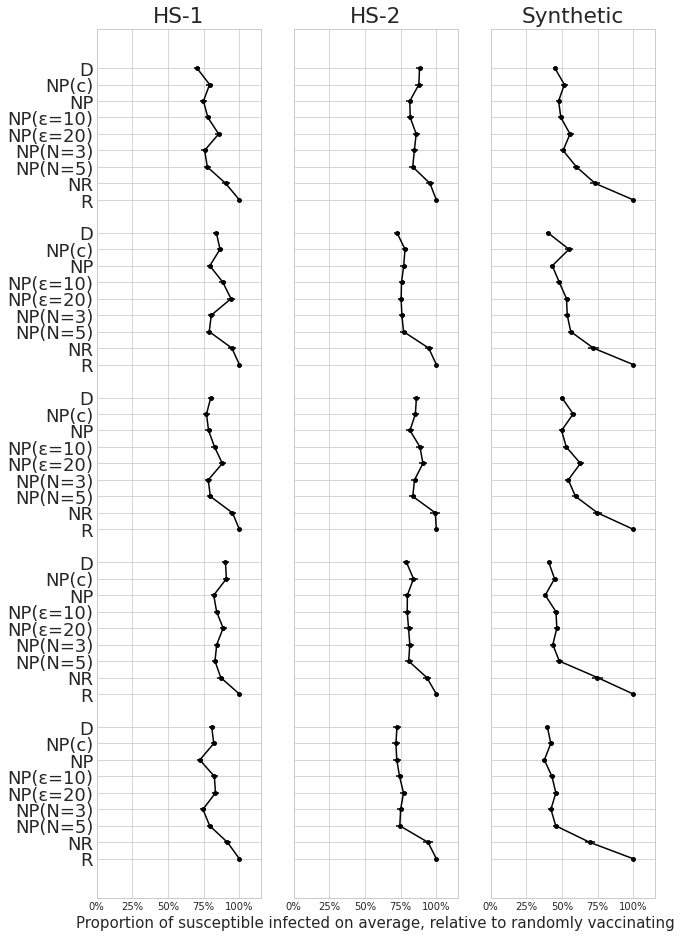

In [27]:
for ci,comp in enumerate(comparisons):
    
    display(Markdown(f"# {comp} = {comparisons[comp]}"))

    plt.figure(figsize=(10,16))
    plt.tight_layout()
    
    for ni, name in enumerate(names):
        #plt.figure(figsize=(5,15 * len(comparisons[comp])/4))
        plt.subplot(1,3,ni+1)
        
        allvs = []
        allys = []
        for Vi,V in enumerate(comparisons[comp]):
            
            sim_m = modelsets[name]
            df = dfs[name]

            svals = []
            for s in strats:
                d = dict(defaults)
                d[comp] = V
                d['strat'] = s

                inf = sim_m.info( fzd( d ) )
                #print(inf['mean'], [x['mean'] for x in svals])

                svals.append(inf)


            #[s['N']s['mean'] for s in svals]

            xs = np.array([1]+[ s['P_sus_inf_rel_rand'] for s in svals ])
            ys = np.linspace(0,0.8,len(svals)+1) + Vi

            #plt.scatter(xs,ys)
            
            xerrs = np.array([0]+[s['P_sus_inf_rel_rand_err'] for s in svals ],)

            plt.errorbar(
                xs, ys,
                xerr = xerrs,
                color='black'
            )
            plt.scatter(xs, ys, s=15, color='black')
            #print([s['min'] for s in svals])
            
            allvs.append( np.min(xs-xerrs)-0.05 )
            allvs.append( np.max(xs+xerrs)+0.05 )
            
            allys += list(ys)

        plt.title(f'{titles[name]}')
        
        ytk = np.linspace(0,1.0,5)
        plt.xticks(ytk, [f'{t:0.0%}' for t in ytk], fontsize=10)
        
        if ni==1:
            plt.xlabel('Proportion of susceptible infected on average, relative to randomly vaccinating', fontsize=15)
            
        plt.xlim( min(allvs),max(allvs) )
        
        if ni==0:
            plt.yticks(
                allys,
                len(comparisons[comp])* (["R"]+[strat_print[s] for s in strats])
            )
        else:
            plt.yticks(
                allys,
                []
            )
        
        #plt.vlines([0.5, 0.75, 1], *plt.ylim())
        plt.grid('y')
        plt.xlim(0,1.15)
        
    plt.savefig(f'figures/{name}.{comp}.png', dpi=300)
    plt.show()